# Set up

# spell-sound association picker

developed by Kow Kurooda (kow.kuroda@gmail.com)

Modifications
2025/03/01 added processing using extended skippy n-gram

In [70]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'
#%pip install -U multiprocess
#!conda update conda -y

In [1]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata
## https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
#import multiprocessing as mp # fails on IPython environment
import multiprocess as mp # provides Pool

# Preparation 1

In [71]:
## parameters
verbose              = True
check                = False
save_results         = False
targets_csv          = True
reload_modules       = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.1 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 11 # values larger than 10 take considerably longer to complete
min_doc_size         =  5

## skippy n-gram
skippy_means_extended = True

## 隙間を表わす記号
gap_mark            = "…"

## preprocessing settings
lower_chars           = True
strip_accents         = False

## boundary marking
mark_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if mark_boundaries:
    if skippy_means_extended:
        add_boundaries       = False
        hash_status = ""
    else:
        add_boundaries       = True
        hash_status = "-hashed"

## term settings
ngram_is_inclusive    = True # takes longer to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
print(f"inclusion_degree: {inclusion_degree}")

max_gap_size_factor   = 0.33 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.
print(f"max_gap_size: {max_gap_size}")


## spell term と sound term の連結記号
pair_mark           = " :: "

## define term_types
## spell
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram',
                  'sp_xsk2gram', 'sp_xsk3gram', 'sp_xsk4gram', 'sp_xsk5gram' ]
## sound
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram',
                 'sn_xsk2gram', 'sn_xsk3gram', 'sn_xsk4gram', 'sn_xsk5gram' ]
if skippy_means_extended:
    sp_term_types = [ t for t in sp_term_types if not "_sk" in t ]
    sn_term_types = [ t for t in sn_term_types if not "_sk" in t ]
else:
    sp_term_types = [ t for t in sp_term_types if not "_xsk" in t ]
    sn_term_types = [ t for t in sn_term_types if not "_xsk" in t ]
if check:
    print(f"sp_term_types: {sp_term_types}")
    print(f"sn_term_types: {sn_term_types}")

## select terms
sp_term_type   = sp_term_types[3]
print(f"sp_term_type: {sp_term_type}")
sn_term_type = sn_term_types[3]
print(f"sn_term_type: {sn_term_type}")

## n_for_ngram
n_sp = sp_term_type.split("gram")[0][-1]
n_sn = sn_term_type.split("gram")[0][-1]
n_for_ngram = max(int(n_sp), int(n_sn))
print(f"n_for_ngram: {n_for_ngram}")

inclusion_degree: 1
max_gap_size: 4
sp_term_type: sp_4gram
sn_term_type: sn_4gram
n_for_ngram: 4


In [139]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 1 # for speeding up; 3 is too large
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.1 # smaller values take longer; larger values reveal deeper; 0.006 seems to be the smallest

In [140]:
## select HDP or LDA: HDP takes considerably longer to complete than LDA with large n_topics,
## n_topics
max_n_topics    = 60
use_HDP         = True
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
    print(f"max_n_topics for HDP: {max_n_topics}")
else:
    method_name  = "LDA"
    print(f"method_name: {method_name}")
    n_topics  = int(max_n_topics/2) # 精度にはあまり影響しない？
    print(f"n_topics for LDA: {n_topics}")

##
n_docs_to_show  = 30
n_terms_to_show = 100
print(f"n_docs_to_show: {n_docs_to_show}")
print(f"n_terms_to_show: {n_terms_to_show}")

# saving output
save_LDAvis          = False
save_topic_structure = False
print(f"save_LDAvis: {save_LDAvis}")
print(f"save_topic_structure: {save_topic_structure}")

## tSNE
top_perplexity_reduct_rate = 0.33
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

# hierarchical clustering
hc_sampling_rate = 0.01
print(f"hc_sampling_rate: {hc_sampling_rate}")

max_n_topics for HDP: 60
n_docs_to_show: 30
n_terms_to_show: 100
save_LDAvis: False
save_topic_structure: False
top_perplexity_reduct_rate: 0.33
hc_sampling_rate: 0.01


In [141]:
## select language and file
lang_names = {  'ar' : 'Arabic',  # 0
                'de' : 'German',  # 1
                'en' : 'English', # 2
                'es' : 'Spanish', # 3
                'fr' : 'French',  # 4
                'sw' : 'Swahili', # 5
                'ir' : 'Irish'    # 6
            }
## selection
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw', 'ir' ]
#
target_lang_key  = lang_keys[-1]
lang_name = lang_names[target_lang_key]
target_lang_attr = ""
print(f"lang_name: {lang_name} ({target_lang_attr}) [lang_key: {target_lang_key}]")
# aliases
target_lang_dict = lang_names
print(f"target_lang_dict: {target_lang_dict}")
target_lang_keys = lang_keys
print(f"target_lang_keys: {target_lang_keys}")
target_lang_key  = target_lang_key
print(f"target_lang_key: {target_lang_key}")
target_lang_attr = target_lang_attr
print(f"target_lang_attr: {target_lang_attr}")

lang_name: Irish () [lang_key: ir]
target_lang_dict: {'ar': 'Arabic', 'de': 'German', 'en': 'English', 'es': 'Spanish', 'fr': 'French', 'sw': 'Swahili', 'ir': 'Irish'}
target_lang_keys: ['ar', 'de', 'en', 'es', 'fr', 'sw', 'ir']
target_lang_key: ir
target_lang_attr: 


In [142]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
data_dir3 = "data/custom-ipa/"

data_files = [ ]
for dir in [ data_dir1, data_dir2, data_dir3 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    data_files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    data_files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    data_files.extend(txt_files)
#
data_files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [143]:
## filter files
data_files = [ file for file in data_files if f"/{target_lang_key}" in file ]
print(data_files)
if len(target_lang_attr) > 0:
    print(f"lang_attr: {target_lang_attr}")
    selected_files = [ file for file in data_files if target_lang_attr in file ]
else:
    selected_files = data_files
selected_files
if len(selected_files) == 0:
    exit()

['data/custom-ipa/ir.csv']


In [144]:
## build data from files
import re, unicodedata
import pandas as pd

check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,díogach,diːɡəx
1,corróg,kɔrˠɔɡ
2,sioc-cheo,sɔːk-xɔː
3,slat,slat
4,geimhleach,ɡɛɪvlæx
...,...,...
1195,gastacht,ɡastaxt
1196,braicheadóir,braːxædɔɪr
1197,sann,sanˠ
1198,cúlchraos,kʊlxraɔs


In [145]:
## modify spell
norm_code = 'NFKC'
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize(norm_code, str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize(norm_code, str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,díogach,diːɡəx
1,corróg,kɔrɣɔɡ
2,sioc-cheo,sɔːk-xɔː
3,slat,slat
4,geimhleach,ɡɛɪvlæx
...,...,...
1195,gastacht,ɡastaxt
1196,braicheadóir,braːxædɔɪr
1197,sann,sanɣ
1198,cúlchraos,kʊlxraɔs


In [146]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,díogach,diːɡəx
1,2,2,corróg,kɔrɣɔɡ
2,3,3,sioc-cheo,sɔːk-xɔː
3,4,4,slat,slat
4,5,5,geimhleach,ɡɛɪvlæx
...,...,...,...,...
1195,1196,1196,gastacht,ɡastaxt
1196,1197,1197,braicheadóir,braːxædɔɪr
1197,1198,1198,sann,sanɣ
1198,1199,1199,cúlchraos,kʊlxraɔs


In [147]:
# filter hyphenated words
len1 = len(df)
df = df[ df['sp_word'].apply(lambda x: x.find("-")) < 0 ]
print(f"discarded {len1- len(df)} rows")

discarded 21 rows


In [148]:
## remove diacritics on sound
removal = r"[ˈˌ ̯'̯]"
df['sn_word'] = df['sn_word'].apply(lambda x: re.sub(removal, "", x))

In [149]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
0,"[d, í, o, g, a, c, h]","[d, i, ː, ɡ, ə, x]"
1,"[c, o, r, r, ó, g]","[k, ɔ, r, ɣ, ɔ, ɡ]"
3,"[s, l, a, t]","[s, l, a, t]"
4,"[g, e, i, m, h, l, e, a, c, h]","[ɡ, ɛ, ɪ, v, l, æ, x]"
5,"[b, a, i, t, í, n, e, a, c, h]","[b, a, ː, t, ɪ, n, æ, x]"
...,...,...
1195,"[g, a, s, t, a, c, h, t]","[ɡ, a, s, t, a, x, t]"
1196,"[b, r, a, i, c, h, e, a, d, ó, i, r]","[b, r, a, ː, x, æ, d, ɔ, ɪ, r]"
1197,"[s, a, n, n]","[s, a, n, ɣ]"
1198,"[c, ú, l, c, h, r, a, o, s]","[k, ʊ, l, x, r, a, ɔ, s]"


In [150]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

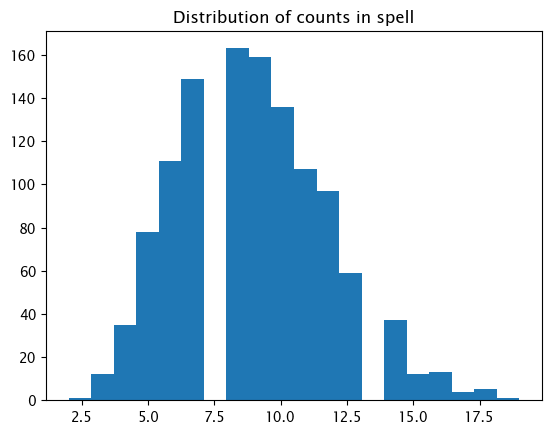

In [151]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

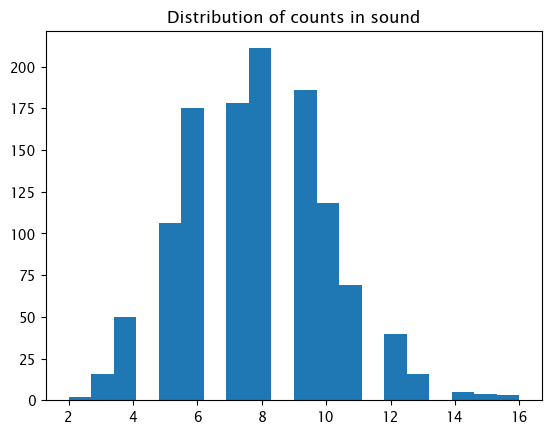

In [152]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

In [153]:
## sampling
max_source_size = 2000
original_size = len(df)
print(f"original_size: {original_size}")
if source_sampling and original_size >= max_source_size:
    sample_size   = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

original_size: 1179


# build terms, part 1

In [154]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 5 chars
discarding pairs whose sn_size part has more than 11 chars
205 (0.174) pairs were removed
974 pairs remain


In [155]:
## add boundaries
def add_boundary_symbols (x):
    if x[0] == boundary_symbol and x[-1] == boundary_symbol:
        return x
    else:
        return f"{boundary_symbol}{x}{boundary_symbol}"

if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: add_boundary_symbols (x))
    df['sn_word'] = df['sn_word'].apply(lambda x: add_boundary_symbols (x))
    df[['sp_word', 'sn_word']]

In [156]:
## generate 1-gram
import re
w_splitter = r""
from unicodedata import normalize as norm
norm_code = "NFKC"

#df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sp_1gram'] = df['sp_word'].apply(lambda w:
                                     [ x for x in re.split(w_splitter, norm(norm_code, w)) if len(x) > 0 ])
#df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df['sn_1gram'] = df['sn_word'].apply(lambda w:
                                     [ x for x in re.split(w_splitter, norm(norm_code, w)) if len(x) > 0 ])
#
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
0,"[d, í, o, g, a, c, h]","[d, i, ː, ɡ, ə, x]"
1,"[c, o, r, r, ó, g]","[k, ɔ, r, ɣ, ɔ, ɡ]"
4,"[g, e, i, m, h, l, e, a, c, h]","[ɡ, ɛ, ɪ, v, l, æ, x]"
5,"[b, a, i, t, í, n, e, a, c, h]","[b, a, ː, t, ɪ, n, æ, x]"
6,"[n, e, a, m, h, c, h, ú, t, h, a, i, l]","[n, æ, v, x, ʊ, h, a, ː, l]"
...,...,...
1193,"[a, i, s, c, h, é, i, m, n, i, g, h]","[a, ː, s, x, ɛ, ɪ, m, n, ɪ, ɣ]"
1195,"[g, a, s, t, a, c, h, t]","[ɡ, a, s, t, a, x, t]"
1196,"[b, r, a, i, c, h, e, a, d, ó, i, r]","[b, r, a, ː, x, æ, d, ɔ, ɪ, r]"
1198,"[c, ú, l, c, h, r, a, o, s]","[k, ʊ, l, x, r, a, ɔ, s]"


In [157]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sp_char_freqs.most_common(10)

[('a', 1216),
 ('h', 761),
 ('i', 752),
 ('c', 674),
 ('r', 547),
 ('n', 486),
 ('l', 473),
 ('t', 427),
 ('e', 419),
 ('o', 385)]

In [158]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('a', 1092),
 ('ɪ', 656),
 ('r', 530),
 ('ɔ', 440),
 ('n', 438),
 ('l', 428),
 ('x', 375),
 ('ː', 363),
 ('s', 362),
 ('t', 334)]

In [159]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [160]:
def gen_ngrams_from_str (t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    import unicodedata
    segs = [ x for x in re.split(sep, unicodedata('NFKC', t)) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [161]:
def add_ngrams (dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippy_means_extended: bool = True, skippiness_symbol: str = "sk", max_distance: int = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    import os
    import multiprocess as mp
    pool = mp.Pool (processes = max(int(os.cpu_count()/2) - 1, 1))
    if skippy:
        if skippy_means_extended:
            ngrams = unigrams.apply(lambda x: gen_ngrams.gen_extended_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check))
        else:
            ngrams = unigrams.apply(lambda x: gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check))
        
    else:
        ngrams = unigrams.apply(lambda x: gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check))
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [162]:
df.columns
#iter(df['sp_1gram'])

Index(['did', 'sid', 'sp_word', 'sn_word', 'sp_1gram', 'sn_1gram', 'sp_size',
       'sn_size'],
      dtype='object')

In [163]:
## sp_2gram の追加
add_ngrams (df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0           [dí, ío, og, ga, ac, ch, d, í, o, g, a, c, h]
1                  [co, or, rr, ró, óg, c, o, r, r, ó, g]
4       [ge, ei, im, mh, hl, le, ea, ac, ch, g, e, i, ...
5       [ba, ai, it, tí, ín, ne, ea, ac, ch, b, a, i, ...
6       [ne, ea, am, mh, hc, ch, hú, út, th, ha, ai, i...
                              ...                        
1193    [ai, is, sc, ch, hé, éi, im, mn, ni, ig, gh, a...
1195    [ga, as, st, ta, ac, ch, ht, g, a, s, t, a, c,...
1196    [br, ra, ai, ic, ch, he, ea, ad, dó, ói, ir, b...
1198    [cú, úl, lc, ch, hr, ra, ao, os, c, ú, l, c, h...
1199        [cr, ro, ob, bh, ha, ar, c, r, o, b, h, a, r]
Name: sp_2gram, Length: 974, dtype: object


In [164]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0       [dío, íog, oga, gac, ach, dí, ío, og, ga, ac, ch]
1                [cor, orr, rró, róg, co, or, rr, ró, óg]
4       [gei, eim, imh, mhl, hle, lea, eac, ach, ge, e...
5       [bai, ait, ití, tín, íne, nea, eac, ach, ba, a...
6       [nea, eam, amh, mhc, hch, chú, hút, úth, tha, ...
                              ...                        
1193    [ais, isc, sch, ché, héi, éim, imn, mni, nig, ...
1195    [gas, ast, sta, tac, ach, cht, ga, as, st, ta,...
1196    [bra, rai, aic, ich, che, hea, ead, adó, dói, ...
1198    [cúl, úlc, lch, chr, hra, rao, aos, cú, úl, lc...
1199    [cro, rob, obh, bha, har, cr, ro, ob, bh, ha, ar]
Name: sp_3gram, Length: 974, dtype: object


In [165]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0       [díog, íoga, ogac, gach, dío, íog, oga, gac, ach]
1                  [corr, orró, rróg, cor, orr, rró, róg]
4       [geim, eimh, imhl, mhle, hlea, leac, each, gei...
5       [bait, aití, itín, tíne, ínea, neac, each, bai...
6       [neam, eamh, amhc, mhch, hchú, chút, húth, úth...
                              ...                        
1193    [aisc, isch, sché, chéi, héim, éimn, imni, mni...
1195    [gast, asta, stac, tach, acht, gas, ast, sta, ...
1196    [brai, raic, aich, iche, chea, head, eadó, adó...
1198    [cúlc, úlch, lchr, chra, hrao, raos, cúl, úlc,...
1199    [crob, robh, obha, bhar, cro, rob, obh, bha, har]
Name: sp_4gram, Length: 974, dtype: object


In [166]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [167]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0       [dí…, d…o…, d…g…, d…a…, …ío…, …í…g…, …í…a…, …o...
1       [co…, c…r…, c…r…, c…ó…, …or…, …o…r…, …o…ó…, …r...
4       [ge…, g…i…, g…m…, g…h…, …ei…, …e…m…, …e…h…, …i...
5       [ba…, b…i…, b…t…, b…í…, …ai…, …a…t…, …a…í…, …i...
6       [ne…, n…a…, n…m…, n…h…, …ea…, …e…m…, …e…h…, …a...
                              ...                        
1193    [ai…, a…s…, a…c…, a…h…, …is…, …i…c…, …i…h…, …s...
1195    [ga…, g…s…, g…t…, g…a…, …as…, …a…t…, …a…a…, …s...
1196    [br…, b…a…, b…i…, b…c…, …ra…, …r…i…, …r…c…, …a...
1198    [cú…, c…l…, c…c…, c…h…, …úl…, …ú…c…, …ú…h…, …l...
1199    [cr…, c…o…, c…b…, c…h…, …ro…, …r…b…, …r…h…, …o...
Name: sp_sk2gram, Length: 974, dtype: object


In [168]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0       [d…ío…, d…í…g…, d…í…a…, d…og…, d…o…a…, d…ga…, ...
1       [c…or…, c…o…r…, c…o…ó…, c…r…, c…r…ó…, c…ró…, …...
4       [g…ei…, g…e…m…, g…e…h…, g…im…, g…i…h…, g…mh…, ...
5       [b…ai…, b…a…t…, b…a…í…, b…it…, b…i…í…, b…tí…, ...
6       [n…ea…, n…e…m…, n…e…h…, n…am…, n…a…h…, n…mh…, ...
                              ...                        
1193    [a…is…, a…i…c…, a…i…h…, a…sc…, a…s…h…, a…ch…, ...
1195    [g…as…, g…a…t…, g…a…a…, g…st…, g…s…a…, g…ta…, ...
1196    [b…ra…, b…r…i…, b…r…c…, b…ai…, b…a…c…, b…ic…, ...
1198    [c…úl…, c…ú…c…, c…ú…h…, c…lc…, c…l…h…, c…ch…, ...
1199    [c…ro…, c…r…b…, c…r…h…, c…ob…, c…o…h…, c…bh…, ...
Name: sp_sk3gram, Length: 974, dtype: object


In [169]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0       [d…í…og…, d…í…o…a…, d…í…ga…, d…o…ga…, …í…o…ga…...
1       [c…o…r…, c…o…r…ó…, c…o…ró…, c…r…ró…, …o…r…ró…,...
4       [g…e…im…, g…e…i…h…, g…e…mh…, g…i…mh…, …e…i…mh…...
5       [b…a…it…, b…a…i…í…, b…a…tí…, b…i…tí…, …a…i…tí…...
6       [n…e…am…, n…e…a…h…, n…e…mh…, n…a…mh…, …e…a…mh…...
                              ...                        
1193    [a…i…sc…, a…i…s…h…, a…i…ch…, a…s…ch…, …i…s…ch…...
1195    [g…a…st…, g…a…s…a…, g…a…ta…, g…s…ta…, …a…s…ta…...
1196    [b…r…ai…, b…r…a…c…, b…r…ic…, b…a…ic…, …r…a…ic…...
1198    [c…ú…lc…, c…ú…l…h…, c…ú…ch…, c…l…ch…, …ú…l…ch…...
1199    [c…r…ob…, c…r…o…h…, c…r…bh…, c…o…bh…, …r…o…bh…...
Name: sp_sk4gram, Length: 974, dtype: object


In [170]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [171]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram
0,díogach,"[dí…, d…o…, d…g…, d…a…, …ío…, …í…g…, …í…a…, …o...","[d…ío…, d…í…g…, d…í…a…, d…og…, d…o…a…, d…ga…, ...","[d…í…og…, d…í…o…a…, d…í…ga…, d…o…ga…, …í…o…ga…..."
1,corróg,"[co…, c…r…, c…r…, c…ó…, …or…, …o…r…, …o…ó…, …r...","[c…or…, c…o…r…, c…o…ó…, c…r…, c…r…ó…, c…ró…, …...","[c…o…r…, c…o…r…ó…, c…o…ró…, c…r…ró…, …o…r…ró…,..."
4,geimhleach,"[ge…, g…i…, g…m…, g…h…, …ei…, …e…m…, …e…h…, …i...","[g…ei…, g…e…m…, g…e…h…, g…im…, g…i…h…, g…mh…, ...","[g…e…im…, g…e…i…h…, g…e…mh…, g…i…mh…, …e…i…mh…..."
5,baitíneach,"[ba…, b…i…, b…t…, b…í…, …ai…, …a…t…, …a…í…, …i...","[b…ai…, b…a…t…, b…a…í…, b…it…, b…i…í…, b…tí…, ...","[b…a…it…, b…a…i…í…, b…a…tí…, b…i…tí…, …a…i…tí…..."
6,neamhchúthail,"[ne…, n…a…, n…m…, n…h…, …ea…, …e…m…, …e…h…, …a...","[n…ea…, n…e…m…, n…e…h…, n…am…, n…a…h…, n…mh…, ...","[n…e…am…, n…e…a…h…, n…e…mh…, n…a…mh…, …e…a…mh…..."
...,...,...,...,...
1193,aischéimnigh,"[ai…, a…s…, a…c…, a…h…, …is…, …i…c…, …i…h…, …s...","[a…is…, a…i…c…, a…i…h…, a…sc…, a…s…h…, a…ch…, ...","[a…i…sc…, a…i…s…h…, a…i…ch…, a…s…ch…, …i…s…ch…..."
1195,gastacht,"[ga…, g…s…, g…t…, g…a…, …as…, …a…t…, …a…a…, …s...","[g…as…, g…a…t…, g…a…a…, g…st…, g…s…a…, g…ta…, ...","[g…a…st…, g…a…s…a…, g…a…ta…, g…s…ta…, …a…s…ta…..."
1196,braicheadóir,"[br…, b…a…, b…i…, b…c…, …ra…, …r…i…, …r…c…, …a...","[b…ra…, b…r…i…, b…r…c…, b…ai…, b…a…c…, b…ic…, ...","[b…r…ai…, b…r…a…c…, b…r…ic…, b…a…ic…, …r…a…ic…..."
1198,cúlchraos,"[cú…, c…l…, c…c…, c…h…, …úl…, …ú…c…, …ú…h…, …l...","[c…úl…, c…ú…c…, c…ú…h…, c…lc…, c…l…h…, c…ch…, ...","[c…ú…lc…, c…ú…l…h…, c…ú…ch…, c…l…ch…, …ú…l…ch…..."


# Sound n-grams 生成

In [172]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0                  [di, iː, ːɡ, ɡə, əx, d, i, ː, ɡ, ə, x]
1                  [kɔ, ɔr, rɣ, ɣɔ, ɔɡ, k, ɔ, r, ɣ, ɔ, ɡ]
4           [ɡɛ, ɛɪ, ɪv, vl, læ, æx, ɡ, ɛ, ɪ, v, l, æ, x]
5       [ba, aː, ːt, tɪ, ɪn, næ, æx, b, a, ː, t, ɪ, n,...
6       [næ, æv, vx, xʊ, ʊh, ha, aː, ːl, n, æ, v, x, ʊ...
                              ...                        
1193    [aː, ːs, sx, xɛ, ɛɪ, ɪm, mn, nɪ, ɪɣ, a, ː, s, ...
1195        [ɡa, as, st, ta, ax, xt, ɡ, a, s, t, a, x, t]
1196    [br, ra, aː, ːx, xæ, æd, dɔ, ɔɪ, ɪr, b, r, a, ...
1198    [kʊ, ʊl, lx, xr, ra, aɔ, ɔs, k, ʊ, l, x, r, a,...
1199               [kr, rɔ, ɔv, va, ar, k, r, ɔ, v, a, r]
Name: sn_2gram, Length: 974, dtype: object


In [173]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0                [diː, iːɡ, ːɡə, ɡəx, di, iː, ːɡ, ɡə, əx]
1                [kɔr, ɔrɣ, rɣɔ, ɣɔɡ, kɔ, ɔr, rɣ, ɣɔ, ɔɡ]
4       [ɡɛɪ, ɛɪv, ɪvl, vlæ, læx, ɡɛ, ɛɪ, ɪv, vl, læ, æx]
5       [baː, aːt, ːtɪ, tɪn, ɪnæ, næx, ba, aː, ːt, tɪ,...
6       [næv, ævx, vxʊ, xʊh, ʊha, haː, aːl, næ, æv, vx...
                              ...                        
1193    [aːs, ːsx, sxɛ, xɛɪ, ɛɪm, ɪmn, mnɪ, nɪɣ, aː, ː...
1195    [ɡas, ast, sta, tax, axt, ɡa, as, st, ta, ax, xt]
1196    [bra, raː, aːx, ːxæ, xæd, ædɔ, dɔɪ, ɔɪr, br, r...
1198    [kʊl, ʊlx, lxr, xra, raɔ, aɔs, kʊ, ʊl, lx, xr,...
1199             [krɔ, rɔv, ɔva, var, kr, rɔ, ɔv, va, ar]
Name: sn_3gram, Length: 974, dtype: object


In [174]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0                  [diːɡ, iːɡə, ːɡəx, diː, iːɡ, ːɡə, ɡəx]
1                  [kɔrɣ, ɔrɣɔ, rɣɔɡ, kɔr, ɔrɣ, rɣɔ, ɣɔɡ]
4       [ɡɛɪv, ɛɪvl, ɪvlæ, vlæx, ɡɛɪ, ɛɪv, ɪvl, vlæ, læx]
5       [baːt, aːtɪ, ːtɪn, tɪnæ, ɪnæx, baː, aːt, ːtɪ, ...
6       [nævx, ævxʊ, vxʊh, xʊha, ʊhaː, haːl, næv, ævx,...
                              ...                        
1193    [aːsx, ːsxɛ, sxɛɪ, xɛɪm, ɛɪmn, ɪmnɪ, mnɪɣ, aːs...
1195    [ɡast, asta, stax, taxt, ɡas, ast, sta, tax, axt]
1196    [braː, raːx, aːxæ, ːxæd, xædɔ, ædɔɪ, dɔɪr, bra...
1198    [kʊlx, ʊlxr, lxra, xraɔ, raɔs, kʊl, ʊlx, lxr, ...
1199               [krɔv, rɔva, ɔvar, krɔ, rɔv, ɔva, var]
Name: sn_4gram, Length: 974, dtype: object


In [175]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [176]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0       [di…, d…ː…, d…ɡ…, d…ə…, …iː…, …i…ɡ…, …i…ə…, …ː...
1       [kɔ…, k…r…, k…ɣ…, k…ɔ…, …ɔr…, …ɔ…ɣ…, …ɔ…ɔ…, …r...
4       [ɡɛ…, ɡ…ɪ…, ɡ…v…, ɡ…l…, …ɛɪ…, …ɛ…v…, …ɛ…l…, …ɪ...
5       [ba…, b…ː…, b…t…, b…ɪ…, …aː…, …a…t…, …a…ɪ…, …ː...
6       [næ…, n…v…, n…x…, n…ʊ…, …æv…, …æ…x…, …æ…ʊ…, …v...
                              ...                        
1193    [aː…, a…s…, a…x…, a…ɛ…, …ːs…, …ː…x…, …ː…ɛ…, …s...
1195    [ɡa…, ɡ…s…, ɡ…t…, ɡ…a…, …as…, …a…t…, …a…a…, …s...
1196    [br…, b…a…, b…ː…, b…x…, …ra…, …r…ː…, …r…x…, …a...
1198    [kʊ…, k…l…, k…x…, k…r…, …ʊl…, …ʊ…x…, …ʊ…r…, …l...
1199    [kr…, k…ɔ…, k…v…, k…a…, …rɔ…, …r…v…, …r…a…, …ɔ...
Name: sn_sk2gram, Length: 974, dtype: object


In [177]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0       [d…iː…, d…i…ɡ…, d…i…ə…, d…ːɡ…, d…ː…ə…, d…ɡə…, ...
1       [k…ɔr…, k…ɔ…ɣ…, k…ɔ…ɔ…, k…rɣ…, k…r…ɔ…, k…ɣɔ…, ...
4       [ɡ…ɛɪ…, ɡ…ɛ…v…, ɡ…ɛ…l…, ɡ…ɪv…, ɡ…ɪ…l…, ɡ…vl…, ...
5       [b…aː…, b…a…t…, b…a…ɪ…, b…ːt…, b…ː…ɪ…, b…tɪ…, ...
6       [n…æv…, n…æ…x…, n…æ…ʊ…, n…vx…, n…v…ʊ…, n…xʊ…, ...
                              ...                        
1193    [a…ːs…, a…ː…x…, a…ː…ɛ…, a…sx…, a…s…ɛ…, a…xɛ…, ...
1195    [ɡ…as…, ɡ…a…t…, ɡ…a…a…, ɡ…st…, ɡ…s…a…, ɡ…ta…, ...
1196    [b…ra…, b…r…ː…, b…r…x…, b…aː…, b…a…x…, b…ːx…, ...
1198    [k…ʊl…, k…ʊ…x…, k…ʊ…r…, k…lx…, k…l…r…, k…xr…, ...
1199    [k…rɔ…, k…r…v…, k…r…a…, k…ɔv…, k…ɔ…a…, k…va…, ...
Name: sn_sk3gram, Length: 974, dtype: object


In [178]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

0       [d…i…ːɡ…, d…i…ː…ə…, d…i…ɡə…, d…ː…ɡə…, …i…ː…ɡə…...
1       [k…ɔ…rɣ…, k…ɔ…r…ɔ…, k…ɔ…ɣɔ…, k…r…ɣɔ…, …ɔ…r…ɣɔ…...
4       [ɡ…ɛ…ɪv…, ɡ…ɛ…ɪ…l…, ɡ…ɛ…vl…, ɡ…ɪ…vl…, …ɛ…ɪ…vl…...
5       [b…a…ːt…, b…a…ː…ɪ…, b…a…tɪ…, b…ː…tɪ…, …a…ː…tɪ…...
6       [n…æ…vx…, n…æ…v…ʊ…, n…æ…xʊ…, n…v…xʊ…, …æ…v…xʊ…...
                              ...                        
1193    [a…ː…sx…, a…ː…s…ɛ…, a…ː…xɛ…, a…s…xɛ…, …ː…s…xɛ…...
1195    [ɡ…a…st…, ɡ…a…s…a…, ɡ…a…ta…, ɡ…s…ta…, …a…s…ta…...
1196    [b…r…aː…, b…r…a…x…, b…r…ːx…, b…a…ːx…, …r…a…ːx…...
1198    [k…ʊ…lx…, k…ʊ…l…r…, k…ʊ…xr…, k…l…xr…, …ʊ…l…xr…...
1199    [k…r…ɔv…, k…r…ɔ…a…, k…r…va…, k…ɔ…va…, …r…ɔ…va…...
Name: sn_sk4gram, Length: 974, dtype: object


In [179]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [180]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram
0,diːɡəx,"[di…, d…ː…, d…ɡ…, d…ə…, …iː…, …i…ɡ…, …i…ə…, …ː...","[d…iː…, d…i…ɡ…, d…i…ə…, d…ːɡ…, d…ː…ə…, d…ɡə…, ...","[d…i…ːɡ…, d…i…ː…ə…, d…i…ɡə…, d…ː…ɡə…, …i…ː…ɡə…..."
1,kɔrɣɔɡ,"[kɔ…, k…r…, k…ɣ…, k…ɔ…, …ɔr…, …ɔ…ɣ…, …ɔ…ɔ…, …r...","[k…ɔr…, k…ɔ…ɣ…, k…ɔ…ɔ…, k…rɣ…, k…r…ɔ…, k…ɣɔ…, ...","[k…ɔ…rɣ…, k…ɔ…r…ɔ…, k…ɔ…ɣɔ…, k…r…ɣɔ…, …ɔ…r…ɣɔ…..."
4,ɡɛɪvlæx,"[ɡɛ…, ɡ…ɪ…, ɡ…v…, ɡ…l…, …ɛɪ…, …ɛ…v…, …ɛ…l…, …ɪ...","[ɡ…ɛɪ…, ɡ…ɛ…v…, ɡ…ɛ…l…, ɡ…ɪv…, ɡ…ɪ…l…, ɡ…vl…, ...","[ɡ…ɛ…ɪv…, ɡ…ɛ…ɪ…l…, ɡ…ɛ…vl…, ɡ…ɪ…vl…, …ɛ…ɪ…vl…..."
5,baːtɪnæx,"[ba…, b…ː…, b…t…, b…ɪ…, …aː…, …a…t…, …a…ɪ…, …ː...","[b…aː…, b…a…t…, b…a…ɪ…, b…ːt…, b…ː…ɪ…, b…tɪ…, ...","[b…a…ːt…, b…a…ː…ɪ…, b…a…tɪ…, b…ː…tɪ…, …a…ː…tɪ…..."
6,nævxʊhaːl,"[næ…, n…v…, n…x…, n…ʊ…, …æv…, …æ…x…, …æ…ʊ…, …v...","[n…æv…, n…æ…x…, n…æ…ʊ…, n…vx…, n…v…ʊ…, n…xʊ…, ...","[n…æ…vx…, n…æ…v…ʊ…, n…æ…xʊ…, n…v…xʊ…, …æ…v…xʊ…..."
...,...,...,...,...
1193,aːsxɛɪmnɪɣ,"[aː…, a…s…, a…x…, a…ɛ…, …ːs…, …ː…x…, …ː…ɛ…, …s...","[a…ːs…, a…ː…x…, a…ː…ɛ…, a…sx…, a…s…ɛ…, a…xɛ…, ...","[a…ː…sx…, a…ː…s…ɛ…, a…ː…xɛ…, a…s…xɛ…, …ː…s…xɛ…..."
1195,ɡastaxt,"[ɡa…, ɡ…s…, ɡ…t…, ɡ…a…, …as…, …a…t…, …a…a…, …s...","[ɡ…as…, ɡ…a…t…, ɡ…a…a…, ɡ…st…, ɡ…s…a…, ɡ…ta…, ...","[ɡ…a…st…, ɡ…a…s…a…, ɡ…a…ta…, ɡ…s…ta…, …a…s…ta…..."
1196,braːxædɔɪr,"[br…, b…a…, b…ː…, b…x…, …ra…, …r…ː…, …r…x…, …a...","[b…ra…, b…r…ː…, b…r…x…, b…aː…, b…a…x…, b…ːx…, ...","[b…r…aː…, b…r…a…x…, b…r…ːx…, b…a…ːx…, …r…a…ːx…..."
1198,kʊlxraɔs,"[kʊ…, k…l…, k…x…, k…r…, …ʊl…, …ʊ…x…, …ʊ…r…, …l...","[k…ʊl…, k…ʊ…x…, k…ʊ…r…, k…lx…, k…l…r…, k…xr…, ...","[k…ʊ…lx…, k…ʊ…l…r…, k…ʊ…xr…, k…l…xr…, …ʊ…l…xr…..."


# Pair = sp term :: sn term の生成

In [181]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_mark}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [182]:
## random sampling
import random
random.sample(random.sample(paired_terms, 1)[0], 20)

['eil :: ɛɪl',
 'ilm :: ɛɪlm',
 'deil :: dɛɪl',
 'dei :: dɛɪ',
 'eilm :: dɛɪl',
 'eil :: dɛɪ',
 'ilm :: ɛɪl',
 'deil :: ɪlm',
 'ilm :: dɛɪl',
 'deil :: ɛɪlm',
 'eilm :: ɪlm',
 'dei :: ɪlm',
 'dei :: dɛɪl',
 'eilm :: ɛɪl',
 'ilm :: dɛɪ',
 'ilm :: ɪlm',
 'dei :: ɛɪl',
 'eil :: dɛɪl',
 'eil :: ɪlm',
 'eil :: ɛɪlm']

In [183]:
## number of sentences
print(len(paired_terms))

974


In [184]:
## total number of units
sum(map(len, paired_terms))

132768

In [185]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
term_type = "paired_term"
df[ ['sp_word', 'sn_word', term_type ] ]

,sp_word,sn_word,paired_term
0,díogach,diːɡəx,"[díog :: diːɡ, díog :: iːɡə, díog :: ːɡəx, dío..."
1,corróg,kɔrɣɔɡ,"[corr :: kɔrɣ, corr :: ɔrɣɔ, corr :: rɣɔɡ, cor..."
4,geimhleach,ɡɛɪvlæx,"[geim :: ɡɛɪv, geim :: ɛɪvl, geim :: ɪvlæ, gei..."
5,baitíneach,baːtɪnæx,"[bait :: baːt, bait :: aːtɪ, bait :: ːtɪn, bai..."
6,neamhchúthail,nævxʊhaːl,"[neam :: nævx, neam :: ævxʊ, neam :: vxʊh, nea..."
...,...,...,...
1193,aischéimnigh,aːsxɛɪmnɪɣ,"[aisc :: aːsx, aisc :: ːsxɛ, aisc :: sxɛɪ, ais..."
1195,gastacht,ɡastaxt,"[gast :: ɡast, gast :: asta, gast :: stax, gas..."
1196,braicheadóir,braːxædɔɪr,"[brai :: braː, brai :: raːx, brai :: aːxæ, bra..."
1198,cúlchraos,kʊlxraɔs,"[cúlc :: kʊlx, cúlc :: ʊlxr, cúlc :: lxra, cúl..."


In [186]:
## select data type and define doc_dict
import random
#doc_dict = { i: x for i, x in enumerate(df['paired_term']) }
sn_dict = { i: x for i, x in enumerate(df['sn_word']) }
sp_dict = { i: x for i, x in enumerate(df['sp_word']) }
## check
#random.sample(list(doc_dict.items()), 3)
#random.sample(list(sn_dict.items()), 5)
random.sample(list(zip(sp_dict.values(), sn_dict.values())), 10)

[('cabhaileog', 'kavaːlɔːɡ'),
 ('purgú', 'pʊrɡʊ'),
 ('rianta', 'rɪanta'),
 ('cranda', 'kranda'),
 ('blocshliabh', 'blɔxlɪav'),
 ('goraí', 'ɡɔraː'),
 ('múirín', 'mʊɪrɪn'),
 ('toice', 'tɪːkɛ'),
 ('bunchostas', 'bʊnxɔstas'),
 ('ateacht', 'atæxt')]

# LDA/HDP の実行

In [187]:
#!conda install gensim -y

In [188]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df[term_type]
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<112968 unique tokens: ['ach :: diː', 'ach :: diːɡ', 'ach :: iːɡ', 'ach :: iːɡə', 'ach :: ɡəx']...>


In [189]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")

## check
print(pair_diction)
if len(pair_diction) < 10:
    raise (ValueError, "Under-resourced")

min freq filter: 1
abuse filter: 0.1
term filtering applied
Dictionary<100000 unique tokens: ['ach :: diː', 'ach :: diːɡ', 'ach :: iːɡ', 'ach :: iːɡə', 'ach :: ɡəx']...>


In [190]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
if len(pair_corpus) < 10:
    #print(f"Under-resourced")
    raise (ValueError, "Under-resourced")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 974
0 empty docs are removed out from pair_corpus


In [191]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 60


# pyLDAvis の実行

In [192]:
##!conda install pyLDAvis -y
#!pip install pyLDAvis
#!conda update conda -y

In [193]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [194]:
## save LDAvis output as a html file
save_LDAvis = save_LDAvis
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(target_lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{target_lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [195]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [196]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
top_perplexity_val = round(max_n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 20


In [197]:
## install plotly if necessary
#!conda install plotly -y

In [198]:
## update nbformat if necessary
#!conda install nbformat -y

In [199]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])

## 3D 散布図にラベルを追加する処理は未実装
#method = "HDP" if use_HDP else "LDA"
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {max_n_topics} topics from {method_name} (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [200]:
## stop if HDP is used
if use_HDP:
    #sys.exit(0)
    pass

# Topic structure inspection

In [201]:
## derive LDA from HDP
pair_lda = pair_hdp.suggested_lda_model()

In [202]:
## topic investigation
import HDP_helper

target_hdp = pair_hdp
documents_topics = np.zeros([target_hdp.m_T, len(pair_corpus)])
for doc_id, c in enumerate(pair_corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        #doc = doc_dict[doc_id]
        sp = sp_dict[doc_id]
        sn = sn_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {sp} :: {sn}")

topic_id 0: 0.0 * rai :: raː + 0.0 * eoi :: ːɪr + 0.0 * oir :: ɔːɪr + 0.0 * oir :: ːɪr + 0.0 * oir :: ɔːɪ + 0.0 * eoi :: ɔːɪ + 0.0 * eoir :: ɔːɪr + 0.0 * eoir :: ːɪr + 0.0 * eoir :: ɔːɪ + 0.0 * eoi :: ɔːɪr + 0.0 * heo :: ːɪr + 0.0 * heo :: hɔː + 0.0 * the :: hɔːɪ + 0.0 * eoir :: hɔːɪ + 0.0 * theo :: hɔː + 0.0 * eoi :: hɔːɪ + 0.0 * heoi :: ɔːɪr + 0.0 * heoi :: hɔː + 0.0 * eoir :: hɔː + 0.0 * oir :: hɔːɪ + 0.0 * ith :: ɔːɪ + 0.0 * heoi :: ːɪr + 0.0 * ith :: ːɪr + 0.0 * heoi :: hɔːɪ + 0.0 * theo :: ːɪr + 0.0 * the :: ɔːɪr + 0.0 * eoi :: hɔː + 0.0 * ithe :: ːɪr + 0.0 * ithe :: ɔːɪr + 0.0 * the :: ɔːɪ + 0.0 * oir :: hɔː + 0.0 * theo :: ɔːɪ + 0.0 * ithe :: hɔː + 0.0 * ith :: ɔːɪr + 0.0 * ith :: hɔːɪ + 0.0 * ith :: hɔː + 0.0 * theo :: hɔːɪ + 0.0 * ithe :: hɔːɪ + 0.0 * heo :: ɔːɪr + 0.0 * ithe :: ɔːɪ + 0.0 * heoi :: ɔːɪ + 0.0 * the :: ːɪr + 0.0 * the :: hɔː + 0.0 * heo :: hɔːɪ + 0.0 * theo :: ɔːɪr + 0.0 * heo :: ɔːɪ + 0.0 * tín :: tɪn + 0.0 * uma :: ʊma + 0.0 * eoir :: ːhɔ + 0.0 * ead :: ɔɪr +

In [203]:
if reload_modules:
    import importlib
    importlib.reload (HDP_helper)

94 rows remain after density filtering, discarding 99906 rows
94 rows remain after size filtering, discarding 0 rows
31 rows remain after size filtering, discarding 63 rows


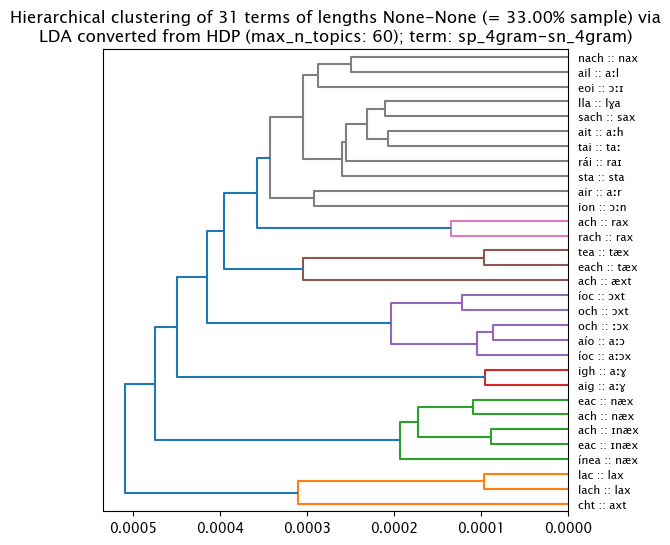

In [204]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
## なるべく高い lowerst_density の設定が肝
HDP_helper.hc_clustering_terms_from_hdp (pair_hdp, pair_diction, term_type = term_type, n_topics= max_n_topics, lowest_density = 0.001, sampling_rate = 0.33, gap_mark = gap_mark, use_CJK = False, check = False)

In [205]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = n_terms_to_show # topic ごとに表示する term 数の指定
print(f"n_terms_to_show: {n_terms_to_show}")

pair_topic_dfs = [ ]
for topic_id in range(max_n_topics):
    print(f"topic_id: {topic_id}")
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_lda.show_topics(topic_id, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic_id, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic_id}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)

## Table として表示
#df_terms_by_topics.T
df_terms_by_topics

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
topic 0,íoga :: iːɡə,íoga :: iːɡ,íoga :: diː,íoga :: diːɡ,íog :: diː,íog :: iːɡ,íog :: ːɡəx,ogac :: ːɡəx,íog :: ːɡə,ogac :: iːɡə,...,ach :: ːɡəx,díog :: diː,dío :: diː,ach :: iːɡ,dío :: iːɡə,ach :: iːɡə,ach :: ːɡə,ach :: ɡəx,ach :: diːɡ,ach :: diː
topic 1,ach :: diː,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 2,íoga :: iːɡə,ach :: diː,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 3,íoga :: iːɡə,ach :: diːɡ,ach :: diː,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 4,íoga :: iːɡə,íoga :: iːɡ,ach :: diːɡ,ach :: diː,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 5,íoga :: iːɡə,íoga :: iːɡ,ach :: ɡəx,ach :: diːɡ,ach :: diː,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 6,íoga :: iːɡə,íoga :: iːɡ,íoga :: diː,ach :: ɡəx,ach :: diːɡ,ach :: diː,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 7,íoga :: iːɡə,íoga :: iːɡ,íoga :: diː,ach :: ːɡə,ach :: ɡəx,ach :: diːɡ,ach :: diː,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 8,íoga :: iːɡə,íoga :: iːɡ,íoga :: diː,íoga :: diːɡ,ach :: ːɡə,ach :: ɡəx,ach :: diːɡ,ach :: diː,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 9,íoga :: iːɡə,íoga :: iːɡ,íoga :: diː,íoga :: diːɡ,ach :: iːɡə,ach :: ːɡə,ach :: ɡəx,ach :: diːɡ,ach :: diː,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
